# Modeling

We've collected and cleaned our data, looked at its main characteristics, and engineered new features based off these. We are now ready to make a predictive model!

## Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
df = pd.read_csv('new_feat_data.csv')
df.drop(columns = ['Unnamed: 0'],inplace=True)

In [3]:
df.head()

,PA,POP,UNDER_5,UNDER_18,65_OR_OVER,FEMALE,WHITE,BLACK,AMERICAN_INDIAN,ASIAN,PACIFIC_ISLANDER,MULTI_RACE,HISPANIC,VETERAN,FOREIGN,HOUSES,HOUSE_VAL,RENT,HOUSEHOLDS,PPH,YEAR_IN_HOUSE,OTHER_HOME_LANG,COMPUTER,INTERNET,HIGH_SCHOOL,BACH_DEGREE,DISABILITY_UNDER_65,NO_INSURANCE,LABOR,FEM_LABOR,TRAVEL_TIME,HOUSEHOLD_INCOME,INCOME,POVERTY,FIRMS,FEM_FIRM,NON_MINOR_FIRM,NON_VET_FIRM,POP_AREA,AREA,LOG_POP,LOG_HOUSE_VAL,LOG_RENT,LOG_HOUSEHOLDS,LOG_PPH,LOG_TRAVEL_TIME,LOG_HOUSEHOLD_INCOME,LOG_INCOME,LOG_FIRMS,LOG_POP_AREA,LOG_AREA,MAJ_FEMALE,MAJ_WHITE,SUPER_WHITE,HOUSE_RATIO,POP_LARGE
0,1,85108.0,0.069,0.254,0.156,0.528,0.727,0.174,0,0.049,0,0.020,0.062,0.054143,0.095,0.691,280400.0,1100.0,32685.0,2.57,0.823,0.128,0.957,0.912,0.963,0.575,0.054,0.065,0.693,0.616,23.9,84042.0,43999.0,0.067,7982.0,0.309572,0.770108,0.820722,1730.6,47.16,11.351676,12.543972,7.003065,10.394672,0.943906,3.173878,11.339072,10.691922,8.984944,7.456223,3.853546,1,1,0,6.372872,1
1,0,68247.0,0.065,0.236,0.172,0.528,0.622,0.340,0,0.011,0,0.019,0.034,0.077967,0.026,0.595,146800.0,735.0,26001.0,2.58,0.855,0.040,0.830,0.743,0.874,0.250,0.122,0.120,0.580,0.526,19.2,45681.0,27648.0,0.191,6620.0,0.385498,0.676435,0.799698,732.6,89.40,11.130889,11.896826,6.599870,10.165890,0.947789,2.954910,10.729438,10.227309,8.797851,6.596600,4.493121,1,1,0,5.309606,1
2,1,101113.0,0.059,0.188,0.117,0.524,0.511,0.441,0,0.024,1,0.011,0.031,0.048550,0.045,0.473,173900.0,843.0,35192.0,2.54,0.760,0.066,0.844,0.759,0.895,0.366,0.078,0.085,0.564,0.535,19.3,44120.0,25364.0,0.242,6802.0,0.371949,0.643193,0.799471,1501.9,60.23,11.523994,12.066236,6.736967,10.468574,0.932164,2.960105,10.694668,10.141086,8.824972,7.314486,4.098171,1,1,0,6.856174,1
3,1,65738.0,0.051,0.183,0.075,0.506,0.729,0.170,0,0.085,0,0.011,0.043,0.033177,0.104,0.441,251000.0,868.0,22850.0,2.53,0.697,0.129,0.953,0.860,0.944,0.567,0.058,0.055,0.583,0.552,19.6,44654.0,27691.0,0.291,4659.0,0.285898,0.751878,0.858339,919.3,58.07,11.093432,12.433208,6.766192,10.036706,0.928219,2.975530,10.706699,10.228863,8.446556,6.823613,4.061649,1,1,0,9.064317,1
4,0,50440.0,0.049,0.244,0.107,0.502,0.741,0.150,0,0.055,0,0.038,0.052,0.092942,0.081,0.699,245000.0,887.0,18591.0,2.58,0.849,0.105,0.961,0.899,0.964,0.575,0.065,0.057,0.682,0.593,19.6,89522.0,45299.0,0.063,3511.0,0.398462,0.745372,0.841356,1450.9,29.59,10.828540,12.409013,6.787845,9.830433,0.947789,2.975530,11.402240,10.721040,8.163656,7.279939,3.387436,1,1,0,5.408508,1


## Feature Selection I

We'll first need to select which features we want to include in our model. 

### Hypothesis Tests for New Features

Let's start by looking at our engineered features:
* `MAJ_FEMALE`
* `MAJ_WHITE`
* `SUPER_WHITE`
* `HOUSE_RATIO`
* `POP_LARGE`

We'll run Z tests on these features to check the following, with the groups meaning the features we made:
_Null Hypothesis: Proportion of different classes among these groups is the same._
_Alternative Hypothesis: Proportion of different classes among these groups is different._

We won't run a hypothesis test on our `HOUSE_RATIO` column because it is the only non-class variable.

If we can reject the null hypothesis, then we know that feature may be useful for our model. Otherwise, we won't use it. We will use a p-value of 0.05.

In [4]:
values = df.groupby(['MAJ_FEMALE','PA']).PA.count()
values

MAJ_FEMALE  PA
0           0      331
            1      301
1           0     1164
            1     1223
Name: PA, dtype: int64

In [5]:
lengths = df.groupby('MAJ_FEMALE')['PA'].count()
lengths

MAJ_FEMALE
0     632
1    2387
Name: PA, dtype: int64

In [6]:
#we'll set our proportions equal to proportion of conservative
pro_1 = values[0][0]/lengths[0] 
pro_2 = values[1][0]/lengths[1] 
pro_overall = (values[0][0]+values[1][0])/(lengths[0]+lengths[1])

print(f'Proportion of conservative cities without a female majority to all cities without a female majority: \n{pro_1}\n')
print(f'Proportion of conservative cities with a female majority to all cities with a female majority: \n{pro_2}\n')
print(f'Proportion of all conservative cities to all cities: \n{pro_overall}\n')

Proportion of conservative cities without a female majority to all cities without a female majority: 
0.5237341772151899

Proportion of conservative cities with a female majority to all cities with a female majority: 
0.4876413908671973

Proportion of all conservative cities to all cities: 
0.4951970851275257



In [7]:
z_score = (pro_1 - pro_2)/np.sqrt((pro_overall*(1-pro_overall))*(1/lengths[0]+1/lengths[1]))
z_score

1.613703110134233

In [8]:
stats.norm.cdf(z_score)

0.9467040804852496

Since this is above our p-value, we cannot reject the null for `MAJ_FEMALE` and as such will remove it from our features.

In [9]:
df.drop(columns = ['MAJ_FEMALE'],inplace=True)

In [10]:
values = df.groupby(['MAJ_WHITE','PA']).PA.count()
lengths = df.groupby('MAJ_WHITE')['PA'].count()

#we'll set our proportions equal to proportion of conservative
pro_1 = values[0][0]/lengths[0] 
pro_2 = values[1][0]/lengths[1] 
pro_overall = (values[0][0]+values[1][0])/(lengths[0]+lengths[1])

print(f'Proportion of conservative cities without a white majority to all cities without a white majority: \n{pro_1}\n')
print(f'Proportion of conservative cities with a white majority to all cities with a white majority: \n{pro_2}\n')
print(f'Proportion of all conservative cities to all cities: \n{pro_overall}\n')

z_score = (pro_1 - pro_2)/np.sqrt((pro_overall*(1-pro_overall))*(1/lengths[0]+1/lengths[1]))

stats.norm.cdf(z_score)

Proportion of conservative cities without a white majority to all cities without a white majority: 
0.13442622950819672

Proportion of conservative cities with a white majority to all cities with a white majority: 
0.5357406042741342

Proportion of all conservative cities to all cities: 
0.4951970851275257



1.3051275880671363e-40

Since this is much lower than our p-value, we reject the null for `MAJ_WHITE`. It looks like this will be a pretty important indicator for our model.

In [11]:
values = df.groupby(['SUPER_WHITE','PA']).PA.count()
lengths = df.groupby('SUPER_WHITE')['PA'].count()

#we'll set our proportions equal to proportion of conservative
pro_1 = values[0][0]/lengths[0] 
pro_2 = values[1][0]/lengths[1] 
pro_overall = (values[0][0]+values[1][0])/(lengths[0]+lengths[1])

print(f'Proportion of conservative cities without a super white majority to all cities without a super white majority: \n{pro_1}\n')
print(f'Proportion of conservative cities with a super white majority to all cities with a super white majority: \n{pro_2}\n')
print(f'Proportion of all conservative cities to all cities: \n{pro_overall}\n')

z_score = (pro_1 - pro_2)/np.sqrt((pro_overall*(1-pro_overall))*(1/lengths[0]+1/lengths[1]))

stats.norm.cdf(z_score)

Proportion of conservative cities without a super white majority to all cities without a super white majority: 
0.43652743652743653

Proportion of conservative cities with a super white majority to all cities with a super white majority: 
0.7435008665511266

Proportion of all conservative cities to all cities: 
0.4951970851275257



1.8677285264742334e-40

In [12]:
z_score

-13.264167574716655

This value is also much lower than our p-value, so we reject the null for `SUPER_WHITE`. As expected, another feature with our `WHITE` column seems to be an important indicator.

In [13]:
values = df.groupby(['POP_LARGE','PA']).PA.count()
lengths = df.groupby('POP_LARGE')['PA'].count()

#we'll set our proportions equal to proportion of conservative
pro_1 = values[0][0]/lengths[0] 
pro_2 = values[1][0]/lengths[1] 
pro_overall = (values[0][0]+values[1][0])/(lengths[0]+lengths[1])
print(f'Proportion of conservative cities without a super white majority to all cities without a super white majority: \n{pro_1}\n')
print(f'Proportion of conservative cities with a super white majority to all cities with a super white majority: \n{pro_2}\n')
print(f'Proportion of all conservative cities to all cities: \n{pro_overall}\n')

z_score = (pro_1 - pro_2)/np.sqrt((pro_overall*(1-pro_overall))*(1/lengths[0]+1/lengths[1]))

stats.norm.cdf(z_score)

Proportion of conservative cities without a super white majority to all cities without a super white majority: 
0.5553335996803835

Proportion of conservative cities with a super white majority to all cities with a super white majority: 
0.20348837209302326

Proportion of all conservative cities to all cities: 
0.4951970851275257



1.0

This z_score is large, so we reject the null for `POP_LARGE`.

### Log Columns

Now that we've made our insights from these values, we'll remove the original columns and keep their logged counterparts, as mentioned in our Data Cleaning section.

In [14]:
logged_columns = [x for x in list(df.columns) if "LOG_" in x]
dropping_columns = [x.replace("LOG_","") for x in logged_columns]
df.drop(columns = dropping_columns,inplace=True)

### Multicollinearity

Let's check our features for multicollinearity. We'll look for anything which has a correlation value of over 0.9.

In [15]:
abs(df.corr()) > 0.85

,PA,UNDER_5,UNDER_18,65_OR_OVER,FEMALE,WHITE,BLACK,AMERICAN_INDIAN,ASIAN,PACIFIC_ISLANDER,MULTI_RACE,HISPANIC,VETERAN,FOREIGN,HOUSES,YEAR_IN_HOUSE,OTHER_HOME_LANG,COMPUTER,INTERNET,HIGH_SCHOOL,BACH_DEGREE,DISABILITY_UNDER_65,NO_INSURANCE,LABOR,FEM_LABOR,POVERTY,FEM_FIRM,NON_MINOR_FIRM,NON_VET_FIRM,LOG_POP,LOG_HOUSE_VAL,LOG_RENT,LOG_HOUSEHOLDS,LOG_PPH,LOG_TRAVEL_TIME,LOG_HOUSEHOLD_INCOME,LOG_INCOME,LOG_FIRMS,LOG_POP_AREA,LOG_AREA,MAJ_WHITE,SUPER_WHITE,HOUSE_RATIO,POP_LARGE
PA,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
UNDER_5,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
UNDER_18,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
65_OR_OVER,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
FEMALE,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
WHITE,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
BLACK,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
AMERICAN_INDIAN,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
ASIAN,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
PACIFIC_ISLANDER,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


Highly correlated features:
* `WHITE` and `BLACK`
* `HISPANIC` and `OTHER_HOME_LANG`
* `FOREIGN` and `OTHER_HOME_LANG`
* `COMPUTER` and `INTERNET`
* `LABOR` and `FEM_LABOR`
* `POVERTY` and `LOG_HOUSEHOLD_INCOME`
* `LOG_HOUSEHOLD_INCOME` and `LOG_INCOME`
* `LOG_POP`, `LOG_HOUSEHOLDS`, and `LOG_FIRMS`

We'll need to remove one from each of these. 

Firstly, we know we cannot remove `WHITE` or `BLACK` because they were both used to make other features. As the collinearity is only a bit higher than 0.85, we'll keep both in, but note that they are highly correlated. Next, we see `OTHER_HOME_LANG` and `LOG_HOUSEHOLD_INCOME` are both correlated to two other features, so we will remove them. We can't remove `LOG_POP` because it is used to make other features, so we'll remove `LOG_HOUSEHOLDS` and `LOG_FIRMS` from this line.

Let's look at just the correlation values between the rest.

In [16]:
corr_df = df[['COMPUTER','INTERNET', 'PA']]
corr_df.corr()

,COMPUTER,INTERNET,PA
COMPUTER,1.000000,0.907505,0.104098
INTERNET,0.907505,1.000000,0.101747
PA,0.104098,0.101747,1.000000


In [17]:
corr_df = df[['LABOR','FEM_LABOR', 'PA']]
corr_df.corr()

,LABOR,FEM_LABOR,PA
LABOR,1.000000,0.878337,0.120627
FEM_LABOR,0.878337,1.000000,0.172227
PA,0.120627,0.172227,1.000000


In [18]:
df.drop(columns = ['OTHER_HOME_LANG','INTERNET','LABOR','LOG_HOUSEHOLD_INCOME','LOG_FIRMS','LOG_HOUSEHOLDS'],inplace=True)

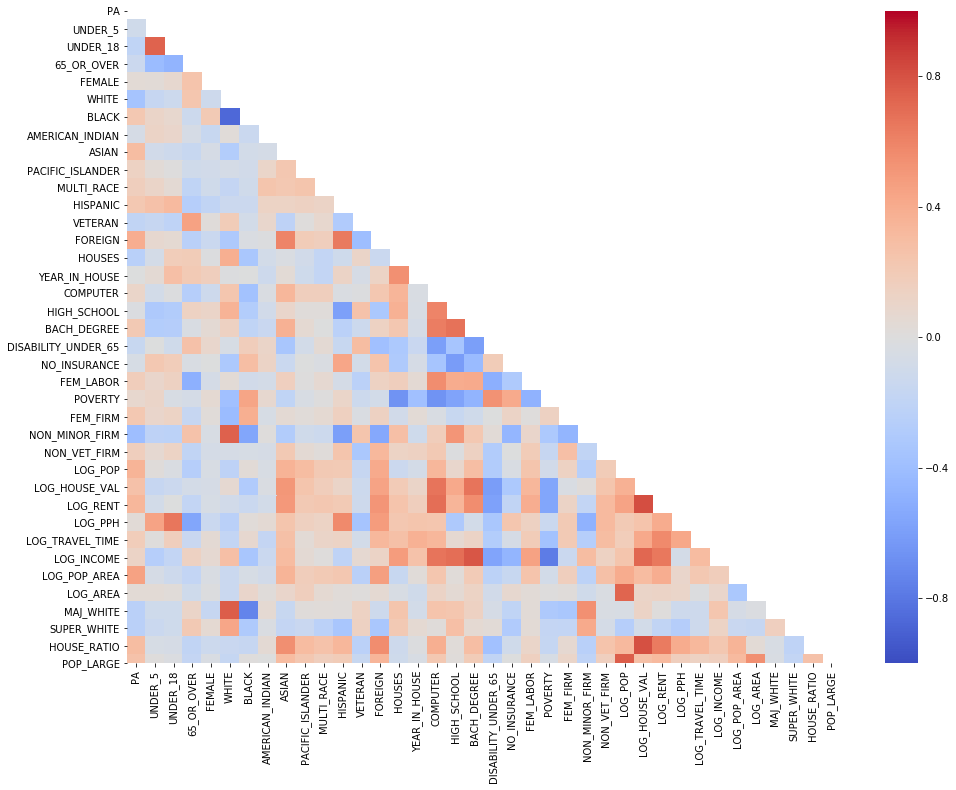

In [21]:
f, ax = plt.subplots(figsize=(16, 12))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask = matrix)

# Base Models

# Feature Selection

multicollinearity <br>
base logistic model and look at weights of paramaters <br>
z test for all engineered features

# Improved Models

# Final Model